### 필요한 라이브러리 불러오기

#### 데이터 개수


- 10년(2012 ~ 2021) * 6개월=184일(5/1~10/31) * 1일(24 * 6) = 264960개

- 1년(2022) * 2개월=79일(5/1~7/18) * 1일(24 * 6) = 11376개

#### Water Data(data_2012.csv)

- ymdhm : 년월일시분
- swl : 팔당댐 현재수위 (단위: El.m)
- inf : 팔당댐 유입량 (단위: m^3/s)
- sfw : 팔당댐 저수량 (단위: 만m^3)
- ecpc : 팔당댐 공용량 (단위: 백만m^3)
- tototf : 총 방류량 (단위: m^3/s)
- tide_level : 강화대교 조위 (단위: cm)
- 
- fw_1018662 : 청담대교 유량 (단위: m^3/s) 주소: 서울특별시 광진구 자양동
- fw_1018680 : 잠수교 유량 (단위: m^3/s) 주소: 서울특별시 서초구 반포동
- fw_1018683 : 한강대교 유량 (단위: m^3/s)    서울특별시 용산구 이촌동
- fw_1019630 : 행주대교 유량 (단위: m^3/s) 주소: 서울특별시 강서구 방화동

-
- wl_1018662 : 청담대교 수위 (단위: cm) 주소: 서울특별시 광진구 자양동
- wl_1018680 : 잠수교 수위 (단위: cm) 주소: 서울특별시 서초구 반포동
- wl_1018683 : 한강대교 수위 (단위: cm) 서울특별시 용산구 이촌동
- wl_1019630 : 행주대교 수위 (단위: cm) 주소: 서울특별시 강서구 방화동

    
#### RainFall Data(rf_2012.csv)

- YMDHM : 년월일시분
- rf_10184100 : 대곡교 강수량 주소: 서울특별시 강남구 세곡동 486-2
- rf_10184110 : 진관교 강수량 주소: 경기도 남양주시 진건읍 신월리
- rf_10184140 : 송정동 강수량 서울특별시 성동구

#### 아이디어

- 저수량

 https://news.g-enews.com/ko-kr/news/article/news_all/2017071623145722580cc1df6cba_1/article.html?md=20170716233512_U

- 팔당댐 강수량(1시간단위)

http://wamis.go.kr/wkw/rf_hrdata.do?code=10174020&organ=01&Search=2&Sort=1&Basin=1&Oper=N&ObsKd=&OrgMng=&name=%25EB%2582%25A8%25EC%2596%2591%25EC%25A3%25BC%25EC%258B%259C(%25ED%258C%2594%25EB%258B%25B9%25EB%258C%2590)

- 팔당댐 현재수위, 유입량, 저수량, 공용량, 방류량 10분 차이



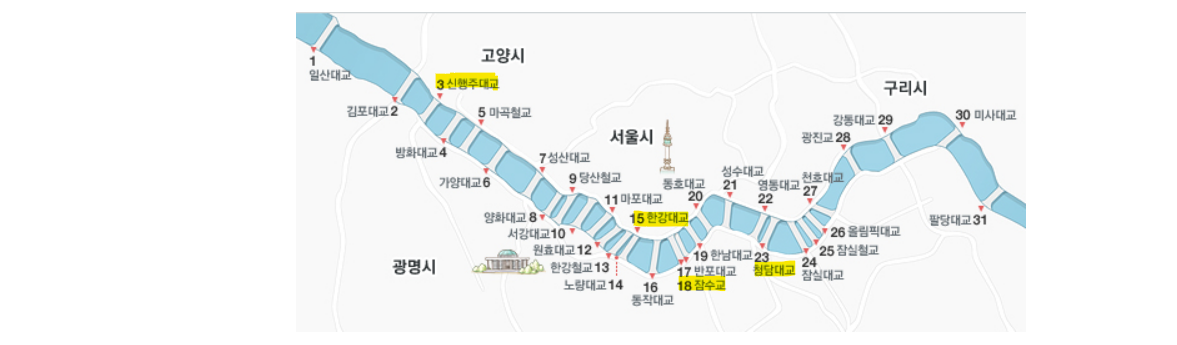

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### pytoch

In [ ]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.23.2 --user
# 설치 후 런타임 다시시작

In [ ]:
import sklearn

!pip install pycaret

from pycaret.utils import enable_colab
enable_colab()

!pip install markupsafe==2.0.1
# 설치 후 런타임 다시시작

In [ ]:
import jinja2
from pycaret.regression import *

!pip install catboost

!pip install optuna

import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

### import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

import os
from glob import glob
from tqdm import tqdm
from scipy import interpolate
import pickle
import datetime as dt
import joblib
import time

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from itertools import permutations, combinations

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_tree, plot_importance
from lightgbm import LGBMRegressor
#from catboost import CatBoostClassifier, Pool, CatBoostRegressor

from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostRegressor,  HistGradientBoostingRegressor, StackingRegressor, RandomForestRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action='ignore')

# 성능 평가
from sklearn.metrics import mean_squared_error
def RMSE(y_pred, y):
    return mean_squared_error(y_pred, y)**0.5

## water_rf_data(water_data + rf_data) 제작
#w_list = sorted(glob("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_data/*.csv"))
#r_list = sorted(glob("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/rf_data/*.csv"))
#for i in list(range(2012, 2023)):
#  globals()['w{0}'.format(i)] = pd.read_csv(w_list[i-2012])
#  globals()['r{0}'.format(i)] = pd.read_csv(r_list[i-2012])
#  globals()['wr{0}'.format(i)] = pd.concat([globals()['w{0}'.format(i)], globals()['r{0}'.format(i)]],axis=1) # 두 데이터프레임 결합
#for i in list(range(2012, 2023)):
#  globals()['wr{0}'.format(i)].to_csv('wr{0}.csv'.format(i), index = False)

wr_list = sorted(glob("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/water_rf_data/*.csv")) # 2012~2021 + 2022-05-01 00:00 ~ 2022-07-18 23:50 
sample_submission = pd.read_csv("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/sample_submission.csv", index_col=0) # 2022-06-01 00:00	~ 2022-07-18 23:50	6912개

In [ ]:
# 전체 데이터프레임 결합(2012~2021년)
df_list = []
for i in wr_list:
    df_list.append(pd.read_csv(i))

df = pd.concat(df_list, ignore_index=True)

# 결측치
df['fw_1018680'] = df['fw_1018680'].fillna(0)
df['sfw_ecpc'] = 244
df = df.drop(['ymdhm.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276336 entries, 0 to 276335
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ymdhm        276336 non-null  object 
 1   swl          275593 non-null  float64
 2   inf          275593 non-null  float64
 3   sfw          275593 non-null  float64
 4   ecpc         275593 non-null  float64
 5   tototf       275593 non-null  float64
 6   tide_level   271409 non-null  float64
 7   wl_1018662   276277 non-null  float64
 8   fw_1018662   259956 non-null  float64
 9   wl_1018680   276277 non-null  float64
 10  fw_1018680   276336 non-null  float64
 11  wl_1018683   276277 non-null  float64
 12  fw_1018683   275057 non-null  float64
 13  wl_1019630   276277 non-null  float64
 14  fw_1019630   276277 non-null  float64
 15  rf_10184100  276336 non-null  float64
 16  rf_10184110  276336 non-null  float64
 17  rf_10184140  276336 non-null  float64
 18  sfw_ecpc     276336 non-

### 데이터 전처리

In [ ]:
def date_conv(df):
    df['ymdhm'] = pd.to_datetime(df['ymdhm'])
    df['year'] = df['ymdhm'].dt.year
    df['month'] =df['ymdhm'].dt.month
    df['day'] =df['ymdhm'].dt.day
    df['hour'] =df['ymdhm'].dt.hour
    df['minute'] =df['ymdhm'].dt.minute
    df['weekday'] = df['ymdhm'].dt.weekday
    #df['year_month_day_hour_minute'] = df['ymdhm'].dt.strftime('%Y-%m-%d-%H-%M')
    df = df.drop('ymdhm', axis=1)
    return df

df = date_conv(df)
#df = df.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'weekday'])
df.shape

(276336, 24)

### 데이터 결측치 + train, val, test 데이터셋 만들기

#### 평균

In [ ]:
# 결측값 
# train['swl,inf,sfw,ecpc,tototf'] = 707, train['wl']=59, train['tide_level']=4923, train['fw_1018662']=15164, train['fw_1019630']=59, train['fw_1018680']=189937, train['fw_1018683']=1279
# test['swl,inf,sfw,ecpc,tototf'] = 36, test['tide_level']=4, test['fw_1018662']=1216, test['fw_1019630']=6912
df.iloc[269424:].isnull().sum()

In [ ]:
# 방법1 평균을 이용한 분석
Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)

train_target = Y.iloc[:269424, :]
train_data = X.iloc[:269424, :]

test_target = Y.iloc[269424:, :]
test_data = X.iloc[269424:, :]

train_target = train_target.fillna(train_target.mean())
train_data = train_data.fillna(train_data.mean())

#test_target.fillna(train_target.fillna(method = 'pad'),inplace=True)
test_data = X.iloc[269423:, :].fillna(method = 'pad')
test_data = test_data.iloc[1:, :]

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(269424, 19) (269424, 4) (6912, 19) (6912, 4)


#### iterative

In [ ]:
# 방법2 iterativeimputer 을 이용한 분석
# 결측치
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 

Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)
X['fw_1018680'] = X['fw_1018680'].fillna(0)

train_target = Y.iloc[:269424, :]
train_data = X.iloc[:269424, :]

test_target = Y.iloc[269424:, :]
test_data = X.iloc[269424:, :]

# 결측치 처리(안해도 된다. 왜냐하면 모델에선 사용안함)
#train_copy = df.copy()
#test_copy = test.copy()

def null(df1):
    df1 = IterativeImputer(random_state=2021).fit_transform(df1)
    df1 = pd.DataFrame(df1)
    df1.columns = df.columns
    #if df1.shape[1] == train_copy.shape[1]:
    #    df1.columns = train_copy.columns
    #else:
    #    df1.columns = test_copy.columns 
    return df1

train = pd.concat([train_target, train_data], axis=1)
train = null(train)
train_target = train[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
train_data = train.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)
#train_target = null(train_target)
#train_data = null(train_data)

#test_target.fillna(train_target.fillna(method = 'pad'),inplace=True)
test_data = X.iloc[269423:, :].fillna(method = 'pad')
test_data = test_data.iloc[1:, :]

#### interpolate

In [ ]:
# 방법3 interpolate 이용한 분석
Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
Y1 = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630", 'year','month','day']]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)


# train, test셋 분리
train_target = Y.iloc[:269424, :]
train_target1 = Y1.iloc[:269424, :]
train_data = X.iloc[:269424, :]
test_target = Y.iloc[269424:, :]
test_target1 = Y1.iloc[269424:, :]
test_data = X.iloc[269424:, :]

# 팔당댐 공용량 결측치 채우기
train_data['ecpc'] = train_data['ecpc'].interpolate()
test_data['ecpc'] = test_data['ecpc'].fillna(method = 'pad')

# 팔당댐 저수량 결측치 채우기
train_data['sfw'] = 244 - train_data['ecpc']
test_data['sfw'] = 244 - test_data['ecpc']

# 나머지 결측치 채우기
train_target = train_target.interpolate()
train_target1 = train_target1.interpolate()
train_data = train_data.interpolate()
test_data = X.iloc[269424:, :].fillna(method = 'pad')

# 총 저수량 제거
train_data = train_data.drop(columns = ['sfw_ecpc'])
test_data = test_data.drop(columns = ['sfw_ecpc'])
df = df.drop(columns = ['sfw_ecpc'])

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(269424, 19) (269424, 4) (6912, 19) (6912, 4)


### 변수 생성

In [ ]:
# 저수량
train_data['water_rate'] = train_data['sfw'] / 244
test_data['water_rate'] = test_data['sfw'] / 244
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(269424, 20) (269424, 4) (6912, 20) (6912, 4)


In [ ]:
train_data.describe()

,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,rf_10184100,rf_10184110,rf_10184140,year,month,day,hour,minute,weekday,swl*inf,swl+inf,swl*sfw,swl+sfw,swl*tototf,swl+tototf,inf*sfw,inf+sfw,inf*tototf,inf+tototf,sfw*tototf,sfw+tototf
count,269424.000000,269424.000000,269424.000000,269424.000000,269424.000000,269424.000000,269424.000000,269424.0,269424.000000,269424.00000,269424.000000,269424.000000,269424.000000,269424.000000,269424.000000,269424.000000,269424.000000,269424.000000,269424.000000,269424.000000,269424.000000,269424.00000,269424.000000,269424.000000,269424.000000,2.694240e+05,269424.000000,2.694240e+05,269424.000000,2.694240e+05,269424.000000
mean,25.073755,543.250722,219.566809,24.433191,537.585862,345.367684,743.558519,0.0,595.157826,1053.69890,0.032781,0.037046,0.034826,2016.591128,7.458578,15.839658,11.500000,25.000000,2.998397,13572.661982,568.324477,5508.12826,244.640564,13429.097665,562.659617,1.172576e+05,762.817531,1.493663e+06,1080.836584,1.159932e+05,757.152671
std,0.463720,1105.704006,10.641605,10.641605,1101.506905,174.291512,1066.437984,0.0,1368.761813,1422.66671,0.331685,0.364152,0.355534,2.933639,1.725490,8.855767,6.922199,17.078283,1.999602,27406.628196,1105.660081,289.50940,10.908099,27293.812403,1101.461428,2.297557e+05,1103.924881,1.032066e+07,2199.805936,2.285727e+05,1099.702239
min,0.000000,-990.000000,-0.010000,2.150000,-990.000000,39.000000,243.290000,0.0,-3522.710000,212.04000,0.000000,0.000000,0.000000,2012.000000,5.000000,1.000000,0.000000,0.000000,0.000000,-20224.645000,-990.000000,0.00000,-0.010000,-10039.400000,-990.000000,-1.838435e+05,-990.010000,-1.285944e+06,-1980.000000,-8.322804e+04,-990.010000
25%,24.980000,127.170000,212.140000,14.390000,132.000000,192.000000,319.840000,0.0,205.230000,449.12000,0.000000,0.000000,0.000000,2014.000000,6.000000,8.000000,5.750000,10.000000,1.000000,3193.790600,152.260000,5307.74280,237.160000,3326.400000,157.174000,2.818509e+04,346.860000,1.618747e+04,258.000000,2.922888e+04,354.770000
50%,25.109000,248.000000,217.970000,26.030000,174.300000,324.000000,447.930000,0.0,354.470000,679.42000,0.000000,0.000000,0.000000,2017.000000,7.000000,16.000000,11.500000,25.000000,3.000000,6215.176850,273.025000,5477.74710,243.129000,4392.960000,199.579000,5.425638e+04,466.775000,4.329600e+04,452.000000,3.835057e+04,395.090000
75%,25.192000,522.000000,229.610000,31.860000,496.800000,487.000000,725.690000,0.0,704.440000,1142.22000,0.000000,0.000000,0.000000,2019.000000,9.000000,24.000000,17.250000,40.000000,5.000000,13062.000000,546.864750,5763.21100,254.710000,12450.000000,521.882000,1.126017e+05,737.520000,2.304000e+05,976.825000,1.067341e+05,712.770000
max,25.449000,25991.500000,241.850000,244.010000,25791.500000,842.000000,9405.640000,0.0,25289.170000,29854.12000,24.000000,21.000000,24.000000,2022.000000,10.000000,31.000000,23.000000,50.000000,6.000000,652906.480000,26016.620000,6152.42215,267.289000,647882.480000,25816.620000,5.986622e+06,26221.830000,6.703598e+08,51783.000000,5.940556e+06,26021.830000


In [ ]:
# swl : 팔당댐 현재수위 (단위: El.m) 0, 23~25
# inf : 팔당댐 유입량 (단위: m^3/s) -990 ~ 25991.5
# sfw : 팔당댐 저수량 (단위: 만m^3)
# ecpc : 팔당댐 공용량 (단위: 백만m^3)
# tototf : 총 방류량 (단위: m^3/s)
# tide_level : 강화대교 조위 (단위: cm)
# fw_1018662 : 청담대교 유량 (단위: m^3/s) 주소: 서울특별시 광진구 자양동
# fw_1018680 : 잠수교 유량 (단위: m^3/s) 주소: 서울특별시 서초구 반포동
# fw_1018683 : 한강대교 유량 (단위: m^3/s) 서울특별시 용산구 이촌동
# fw_1019630 : 행주대교 유량 (단위: m^3/s) 주소: 서울특별시 강서구 방화동

from itertools import permutations, combinations

target_columns1 = ['swl', 'inf', 'sfw', 'tototf']
target_columns2 = ['fw_1018683', 'fw_1019630']

combis1 = list(combinations(target_columns1, 2))
combis2 = list(combinations(target_columns2, 2))

for com in combis1:
    train_data['{}*{}'.format(com[0], com[1])] = train_data['{}'.format(com[0])] * train_data['{}'.format(com[1])]
    test_data['{}*{}'.format(com[0], com[1])] = test_data['{}'.format(com[0])] * test_data['{}'.format(com[1])]
    train_data['{}+{}'.format(com[0], com[1])] = train_data['{}'.format(com[0])] + train_data['{}'.format(com[1])]
    test_data['{}+{}'.format(com[0], com[1])] = test_data['{}'.format(com[0])] + test_data['{}'.format(com[1])]
    
for com in combis2:
    train_data['{}/{}'.format(com[0], com[1])] = train_data['{}'.format(com[0])] / train_data['{}'.format(com[1])]
    test_data['{}/{}'.format(com[0], com[1])] = test_data['{}'.format(com[0])] / test_data['{}'.format(com[1])]
    
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(269424, 32) (269424, 4) (6912, 32) (6912, 4)


### train, val, test 데이터셋 만들기

In [ ]:
Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)

X_train = X.iloc[:251712, :]
y_train = Y.iloc[:251712, :]

X_val = X.iloc[251712:269424, :]
y_val = Y.iloc[251712:269424, :]

X_test = X.iloc[269424:, :]
y_test = Y.iloc[269424:, :] # =submission

train_data = X.iloc[:269424, :]
train_target = Y.iloc[:269424, :]
test_data = X.iloc[269424:, :]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(251712, 19) (251712, 4) (17712, 19) (17712, 4) (6912, 19) (6912, 4)


### 제작 model

In [ ]:
ada = create_model('ada')


In [ ]:
# 1시간 10분
from catboost import CatBoostClassifier, CatBoostRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning) #경고메세지 끄기
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

# 데이터
df_train = df.iloc[:269424, :]

# 모델링
model = setup(df_train, target = 'wl_1018662', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True, ignore_low_variance = True,
              pca = False, normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
top5 = compare_models(exclude = ['svm', 'knn', 'huber', 'lasso', 'ada', 'dt', 'lr'],round=4,n_select=5,sort='RMSE') # 전체 : rf, et,catboost, lightgbm, gbr 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0487,0.0819,0.2858,0.9999,0.0011,0.0002,20.835
et,Extra Trees Regressor,0.0493,0.0849,0.2908,0.9999,0.0011,0.0002,7.916
catboost,CatBoost Regressor,0.1593,0.1541,0.3925,0.9999,0.0014,0.0005,16.843
lightgbm,Light Gradient Boosting Machine,0.1257,0.1831,0.4259,0.9999,0.0015,0.0004,0.641
gbr,Gradient Boosting Regressor,0.8226,1.6424,1.2811,0.9989,0.0043,0.0027,12.383
ridge,Ridge Regression,4.4284,34.5418,5.8771,0.9773,0.0187,0.0142,0.315
lar,Least Angle Regression,4.4284,34.5418,5.8771,0.9773,0.0187,0.0142,0.037
br,Bayesian Ridge,4.4284,34.5418,5.8771,0.9773,0.0187,0.0142,0.047
par,Passive Aggressive Regressor,5.3615,50.3656,7.0738,0.9669,0.0224,0.0171,0.147
omp,Orthogonal Matching Pursuit,5.5954,61.6607,7.8522,0.9594,0.0242,0.0177,0.040


In [ ]:
models = []
X_train1 = X.iloc[:269424, :]
y_train1 = Y.iloc[:269424, :]
top5 = finalize_model(top5)
final_model = top5.fit(X_train1, y_train1)
models.append(final_model)

NameError: ignored

In [ ]:
# 모델 저장(2.37GB)
import joblib

joblib.dump(top5, open('top5.model', 'wb'))

In [ ]:
# 모델 불러오기
top = joblib.load(open('./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/top5.model', 'rb'))  

In [ ]:
# 1시간 20분
tuned_top5 = [tune_model(i) for i in top5] # 모델 안의 파라미터 값 튜닝
blender_top5 = blend_models(estimator_list=tuned_top5) # 5개의 모델을 혼합한 모델
final_model = finalize_model(blender_top5)
final_model

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:37:01
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Fold,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
dt = create_model('dt')
rf = create_mocdl('rf')
ada = create_model('ada')

blender_specific = blend_models(estimator_list = [dt, rf, ada], method = 'soft')


In [ ]:
# 모델 저장
import joblib

joblib.dump(final_model, open('final_model.model', 'wb'))

In [ ]:
models = []
X_train1 = X.iloc[:269424, :]
y_train1 = Y.iloc[:269424, :]

# 모델 학습
final_model = top.fit(X_train1, y_train1)
models.append(final_model

AttributeError: ignored

In [ ]:
# 모델 저장
import joblib

joblib.dump(models, open('model{0}.model'.format(i), 'wb'))

### 전체 pycaret

In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning) #경고메세지 끄기
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

# 데이터
df_train = df.iloc[:269424, :]
X_train1 = X.iloc[:269424, :]
y_train1 = Y.iloc[:269424, :]

# 모델링
models = []
for j in ["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]:
  model = setup(df_train, target = j, fold_shuffle=True, fold=10, 
                session_id=530, remove_multicollinearity = True, ignore_low_variance = True,
                pca = False, normalize= True, n_jobs = -1, silent = True, remove_outliers= True
                )
  top5 = compare_models(exclude = ['svm'],round=4,n_select=5,sort='RMSE')
  tuned_top5 = [tune_model(i) for i in top5] # 모델 안의 파라미터 값 튜닝
  blender_top5 = blend_models(estimator_list=tuned_top5) # 5개의 모델을 혼합한 모델
  final_model = finalize_model(blender_top5)
  final_model = final_model.fit(X_train1, y_train1)
  models.append(final_model)

In [ ]:
X_test1 = X.iloc[269424:, :]

preds = []
for i in range(4):
  pred = models[i].predict(X_test1)
preds.append(pred)

### model(publlic:3.2523364354)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

# 데이터
Y = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]
X = df.drop(columns=["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"], axis=1)
#X = df[["hour", "minute", "weekday"]]
train_data = X.iloc[:269424, :]
train_target = Y.iloc[:269424, :]
test_data = X.iloc[269424:, :]

# 모델
kfold = KFold(n_splits=2, shuffle=True)
#params = {"n_estimators" : (100, 150, 200)}
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)

# 학습, 예측
rf.fit(train_data, train_target)
y_pred = rf.predict(test_data)

sample_submission.iloc[:,:] = y_pred
sample_submission.to_csv('ans.csv')
sample_submission

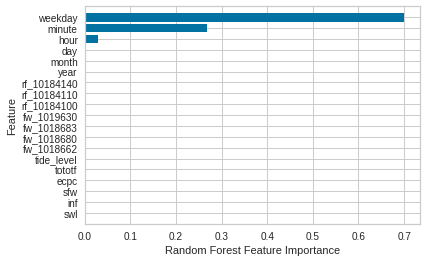

In [ ]:
def plot_feature_importance(model):
    n_features = train_data.shape[1]
    plt.barh(np.arange(n_features), sorted(model.feature_importances_), align="center")
    plt.yticks(np.arange(n_features), train_data.columns)
    plt.xlabel("Random Forest Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importance(rf)

### 모델링 및 모델 학습

In [ ]:
import gc
gc.collect()

88

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from tensorflow.keras import layers
#from tensorflow.keras import layers as L

input_shape = (train_data[0].shape[0], train_data[0].shape[1])

# https://buomsoo-kim.github.io/keras/2019/08/02/Easy-deep-learning-with-Keras-22.md/ : CuDNN을 활용한 GRU


model = Sequential()
model.add(GRU(256, return_sequences = True, input_shape=input_shape))
model.add(GRU(128, return_sequences = False)) 
model.add(Dense(4, activation = 'relu'))

#inputs = L.Input(shape = (data_for_scaler.shape[1], data_for_scaler.shape[2]))
#gru1 = L.GRU(256, return_sequences = True, dropout = 0.2)(inputs)
#ap = L.AveragePooling1D()(gru1)
#gru2 = L.GRU(150, return_sequences = True)(ap)
#GAP = L.GlobalAveragePooling1D()(gru2)
#dense = L.Dense(61, activation = "softmax")(GAP)

#optimizer = tf.optimizers.RMSprop(0.001)
optimizer = tf.optimizers.Adam(0.001)
#optimizer = tf.optimizers.AdamW(0.001)


model.compile(optimizer=optimizer,loss='mse', metrics=['mae'])

In [ ]:
def cudnn_gru_model():
    model = Sequential()
    model.add(CuDNNGRU(50, input_shape = (300,1), return_sequences = True))
    model.add(CuDNNGRU(1, return_sequences = False))
    model.add(Activation('sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [ ]:
model.fit(train_data, train_label, epochs=10, batch_size=128)

Epoch 1/10
2037/2037 [==============================] - 154s 72ms/step - loss: 46245.2617 - mae: 195.2990
Epoch 2/10
2037/2037 [==============================] - 150s 74ms/step - loss: 6935.7695 - mae: 52.7049
Epoch 3/10
2037/2037 [==============================] - 150s 74ms/step - loss: 3313.0037 - mae: 26.5996
Epoch 4/10
2037/2037 [==============================] - 150s 74ms/step - loss: 1470.4374 - mae: 11.2595
Epoch 5/10
2037/2037 [==============================] - 150s 73ms/step - loss: 774.6173 - mae: 8.8993
Epoch 6/10
2037/2037 [==============================] - 150s 73ms/step - loss: 510.9503 - mae: 8.7359
Epoch 7/10
2037/2037 [==============================] - 149s 73ms/step - loss: 411.4238 - mae: 8.8388
Epoch 8/10
2037/2037 [==============================] - 149s 73ms/step - loss: 368.9583 - mae: 8.5363
Epoch 9/10
2037/2037 [==============================] - 149s 73ms/step - loss: 303.2803 - mae: 8.5472
Epoch 10/10
2037/2037 [==============================] - 148s 72ms/step 

### 추론 데이터셋 만들기

In [ ]:
test_data = []
test_label = []

tmp = pd.read_csv(w_list[-1])
tmp = tmp.replace(" ", np.nan)
# 이전값을 사용
tmp = tmp.fillna(method = 'pad')
tmp = tmp.fillna(0)
    
#tmp.loc[:, ["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]] = tmp.loc[:, ["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630"]]*100
    
for j in tqdm(range(4032, len(tmp)-432)):
    test_data.append(np.array(tmp.loc[j:j + 431, ["swl", "inf", "sfw", "ecpc",
                                                    "tototf", "tide_level",
                                                    "fw_1018662", "fw_1018680",
                                                    "fw_1018683", "fw_1019630"]]).astype(float))
        
    test_label.append(np.array(tmp.loc[j + 432, ["wl_1018662", "wl_1018680",
                                                    "wl_1018683", "wl_1019630"]]).astype(float))

100%|██████████| 6912/6912 [00:07<00:00, 978.91it/s]


In [ ]:
test_data = np.array(test_data)
test_label = np.array(test_label)

print(test_data.shape)
print(test_label.shape)

(6912, 432, 10)
(6912, 4)


#### 제출 파일 만들기

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred = pd.DataFrame(pred)

In [ ]:
sample_submission = pd.read_csv("./drive/MyDrive/input/팔당댐 홍수 안전운영에 따른 한강 수위예측/sample_submission.csv")

sample_submission["wl_1018662"] = pred[0]
sample_submission["wl_1018680"] = pred[1]
sample_submission["wl_1018683"] = pred[2]
sample_submission["wl_1019630"] = pred[3]

In [ ]:
sample_submission.to_csv("baseline.csv", index = False)

### rf(3.32)

In [ ]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# 2012~2020 데이터(train), 2021 데이터(test)
X_train = train_data.iloc[:242928, :]
y_train = train_target.iloc[:242928, :] # 12년 5/1 ~ 21년 5/31
X_val = train_data.iloc[242928:249840, :] # 21년 6/1~7/18
y_val = train_target.iloc[242928:249840, :]

# 매개변수
params = {'n_estimators': [200, 400, 500, 600], 
          'max_features': [12, 14, 16, 18]
          }

rf = RandomForestRegressor(n_estimators=500)
model = RandomizedSearchCV(rf, param_distributions = params, n_iter = 30, cv = 5, n_jobs = -1)
rf.fit(X_train, y_train)
pred = rf.predict(X_val)

# RMSE로 예측 평가
rmse = RMSE(pred, y_val) #2.5508483611995882
print(rmse)
# 기본 : 2.5596991093543573
# ['swl', 'inf', 'sfw', 'tototf'] => 2.5593557585594993
# ['swl', 'inf', 'sfw', 'tototf'] + ['fw_1018683', 'fw_1019630'] => 2.584312471952861


2.5596991093543573


In [ ]:
rf = RandomForestRegressor(n_estimators=500)
rf.fit(train_data, train_target)
pred = rf.predict(test_data)
sample_submission.iloc[:,:] = pred
sample_submission.to_csv('ans1.csv')
sample_submission

KeyboardInterrupt: ignored

In [ ]:
train_data56 = train_data[train_data['month']<=6]
train_data7 = train_data[(train_data['month']==7) & (train_data['day']<=18)]
train_data567 = pd.concat([train_data56, train_data7], axis=0)
train_data567

train_target56 = train_target1[(train_target1['month']<=6)]
train_target7 = train_target1[(train_target1['month']==7) & (train_target1['day']<=18)]
train_target567 = pd.concat([train_target56, train_target7], axis=0)
train_target567 = train_target567.drop(['year','month','day'], axis=1)
train_target567

,wl_1018662,wl_1018680,wl_1018683,wl_1019630
0,310.7,300.2,290.0,275.3
1,314.7,300.2,290.0,275.3
2,313.7,301.2,290.0,275.3
3,311.7,301.2,290.0,276.3
4,311.7,301.2,291.0,277.3
...,...,...,...,...
249835,298.7,289.2,291.0,274.3
249836,298.7,291.2,293.0,274.3
249837,299.7,293.2,294.0,275.3
249838,300.7,292.2,292.0,276.3


In [ ]:
#train_target1 = df[["wl_1018662", "wl_1018680", "wl_1018683", "wl_1019630", 'year','month','day']].iloc[:242928, :]
train_target567 = pd.DataFrame()
for i in range(2012, 2022):
  train_target56 = train_target1[(train_target1['year']==i) & (train_target1['month']<=6)]
  train_target7 = train_target1[(train_target1['year']==i) & (train_target1['month']==7) & (train_target1['day']<=18)]
  train_target567 = pd.concat([train_target56, train_target7], axis=0)
#train_target567 = train_target567.drop(columns = ['year','month','day'], axis=1)
train_target567

,wl_1018662,wl_1018680,wl_1018683,wl_1019630,year,month,day
238464,361.7,346.2,340.0,301.3,2021,5,1
238465,356.7,338.2,335.0,308.3,2021,5,1
238466,347.7,331.2,331.0,313.3,2021,5,1
238467,337.7,327.2,329.0,315.3,2021,5,1
238468,328.7,323.2,327.0,316.3,2021,5,1
...,...,...,...,...,...,...,...
249835,298.7,289.2,291.0,274.3,2021,7,18
249836,298.7,291.2,293.0,274.3,2021,7,18
249837,299.7,293.2,294.0,275.3,2021,7,18
249838,300.7,292.2,292.0,276.3,2021,7,18


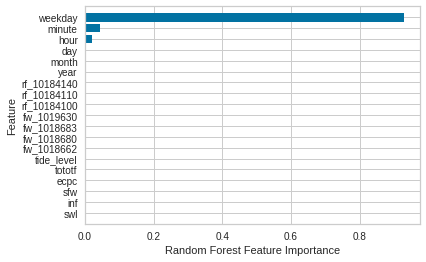

In [ ]:
def plot_feature_importance(model):
    n_features = X_train.shape[1]
    plt.barh(np.arange(n_features), sorted(model.feature_importances_), align="center")
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Random Forest Feature Importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    
plot_feature_importance(rf)

In [ ]:
train_data

,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,rf_10184100,rf_10184110,rf_10184140,year,month,day,hour,minute,weekday
0,24.800,555.00,219.07,24.93,555.00,445.0,469.05,0.0,729.80,540.18,0.0,0.0,0.0,2012,5,1,0,0,1
1,24.794,464.60,218.85,25.15,562.90,449.0,498.00,0.0,731.48,540.18,0.0,0.0,0.0,2012,5,1,0,10,1
2,24.789,478.10,218.69,25.31,576.40,451.0,490.68,0.0,726.42,540.18,0.0,0.0,0.0,2012,5,1,0,20,1
3,24.789,464.80,218.69,25.31,563.10,452.0,476.21,0.0,726.42,552.17,0.0,0.0,0.0,2012,5,1,0,30,1
4,24.789,478.10,218.69,25.31,576.40,450.0,476.21,0.0,707.17,564.29,0.0,0.0,0.0,2012,5,1,0,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269419,25.180,140.94,217.99,26.01,140.94,220.0,285.72,0.0,575.57,493.58,0.0,0.0,0.0,2022,5,31,23,10,1
269420,25.180,141.07,217.99,26.01,141.07,208.0,274.78,0.0,501.04,505.03,0.0,0.0,0.0,2022,5,31,23,20,1
269421,25.180,141.01,217.99,26.01,141.01,196.0,269.40,0.0,425.89,505.03,0.0,0.0,0.0,2022,5,31,23,30,1
269422,25.190,755.75,218.36,25.64,140.75,184.0,264.07,0.0,198.19,493.58,0.0,0.0,0.0,2022,5,31,23,40,1


In [ ]:
# 수동(22분 20.88gb)
rf = RandomForestRegressor()
#model = RandomizedSearchCV(rf, param_distributions = params, n_iter = 30, cv = 5, n_jobs = -1)
rf.fit(train_data, train_target)

pred = rf.predict(test_data)
sample_submission.iloc[:,:] = pred
sample_submission.to_csv('ans1.csv')
sample_submission

In [ ]:
X_train = train_data.iloc[:242928, :]
X_val = train_data.iloc[242928:249840, :]
X_val

,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,rf_10184100,rf_10184110,rf_10184140,year,month,day,hour,minute,weekday,water_rate
242928,24.93,436.0,208.88,35.12,336.0,386.0,413.83,0.0,307.54,805.46,0.0,0.0,0.0,2021,6,1,0,0,1,0.856066
242929,24.93,496.0,208.88,35.12,396.0,371.0,400.58,0.0,158.92,790.92,0.0,0.0,0.0,2021,6,1,0,10,1,0.856066
242930,24.92,471.0,208.52,35.48,471.0,357.0,400.58,0.0,34.46,734.09,0.0,0.0,0.0,2021,6,1,0,20,1,0.854590
242931,24.93,474.0,208.88,35.12,474.0,342.0,413.83,0.0,25.88,679.42,0.0,0.0,0.0,2021,6,1,0,30,1,0.856066
242932,24.93,474.0,208.88,35.12,474.0,329.0,454.91,0.0,0.00,652.89,0.0,0.0,0.0,2021,6,1,0,40,1,0.856066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249835,24.80,549.0,204.07,39.93,549.0,494.0,387.55,0.0,552.55,528.33,0.0,0.0,0.0,2021,7,18,23,10,6,0.836352
249836,24.80,549.0,204.07,39.93,549.0,508.0,387.55,0.0,524.50,528.33,0.0,0.0,0.0,2021,7,18,23,20,6,0.836352
249837,24.79,441.0,203.67,40.33,552.0,521.0,394.04,0.0,537.94,540.18,0.0,0.0,0.0,2021,7,18,23,30,6,0.834713
249838,24.77,220.0,202.87,41.13,552.0,533.0,400.58,0.0,658.93,552.17,0.0,0.0,0.0,2021,7,18,23,40,6,0.831434


In [ ]:
test_data

,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,rf_10184100,rf_10184110,rf_10184140,year,month,day,hour,minute,weekday,water_rate
269424,25.19,140.60,218.36,25.64,140.60,162.0,269.40,0.0,8.23,471.08,0.0,0.0,0.0,2022,6,1,0,0,2,0.894918
269425,25.19,140.78,218.36,25.64,140.78,151.0,280.22,0.0,28.82,449.12,0.0,0.0,0.0,2022,6,1,0,10,2,0.894918
269426,25.20,755.90,218.73,25.27,140.90,141.0,296.87,0.0,12.35,417.17,0.0,0.0,0.0,2022,6,1,0,20,2,0.896434
269427,25.19,0.00,218.36,25.64,140.94,130.0,302.53,0.0,53.52,386.43,0.0,0.0,0.0,2022,6,1,0,30,2,0.894918
269428,25.19,140.63,218.36,25.64,140.63,120.0,296.87,0.0,107.04,366.60,0.0,0.0,0.0,2022,6,1,0,40,2,0.894918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,25.04,259.23,212.86,31.14,259.23,510.0,319.84,0.0,-456.41,974.40,0.0,0.0,0.0,2022,7,18,23,10,0,0.872377
276332,25.04,260.46,212.86,31.14,260.46,492.0,314.01,0.0,-717.30,1006.88,0.0,0.0,0.0,2022,7,18,23,20,0,0.872377
276333,25.04,259.37,212.86,31.14,259.37,475.0,387.55,0.0,-843.37,1039.90,0.0,0.0,0.0,2022,7,18,23,30,0,0.872377
276334,25.04,259.13,212.86,31.14,259.13,458.0,454.91,0.0,-1023.37,1073.46,0.0,0.0,0.0,2022,7,18,23,40,0,0.872377


In [ ]:
model = RandomizedSearchCV(cat, param_distributions = params, n_iter = 30, cv = 5, n_jobs = -1)
model.fit(X_train, y_train)

### rf interpolate

In [ ]:
# 3시간
from optuna import Trial, visualization
import numpy as np

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 800, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 10, X.shape[1], step=1), # 변수의 개수
        #'max_depth' : trial.suggest_int("max_depth", 2, 8) # 기본값=None(무제한)
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, train_data.values, train_target.values), n_trials=15)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))
# {'n_estimators': 770, 'max_features': 11}. Best is trial 0 with value: 1.520065269495061
# {'n_estimators': 640, 'max_features': 12}. Best is trial 4 with value: 1.5262353022330093.


[I 2022-08-08 13:05:05,958] A new study created in memory with name: no-name-561f70a7-d2d7-4349-bd11-59f06b023612
[I 2022-08-08 13:21:18,015] Trial 0 finished with value: 1.5432074739077968 and parameters: {'n_estimators': 560, 'max_features': 12}. Best is trial 0 with value: 1.5432074739077968.
[I 2022-08-08 13:37:07,954] Trial 1 finished with value: 1.6082299933434234 and parameters: {'n_estimators': 400, 'max_features': 18}. Best is trial 0 with value: 1.5432074739077968.
[I 2022-08-08 13:51:27,509] Trial 2 finished with value: 1.530075021426308 and parameters: {'n_estimators': 480, 'max_features': 13}. Best is trial 2 with value: 1.530075021426308.
[I 2022-08-08 14:13:27,079] Trial 3 finished with value: 1.5786516794614085 and parameters: {'n_estimators': 610, 'max_features': 16}. Best is trial 2 with value: 1.530075021426308.
[I 2022-08-08 14:31:17,274] Trial 4 finished with value: 1.5262353022330093 and parameters: {'n_estimators': 640, 'max_features': 12}. Best is trial 4 with v

KeyboardInterrupt: ignored

In [ ]:
# 수동(22분 20.88gb)
rf = RandomForestRegressor(n_estimators=770, max_features=11) # 30분
rf.fit(train_data, train_target)
pred3 = rf.predict(test_data)
sample_submission.iloc[:,:] = pred3
sample_submission.to_csv('ans1.csv')
sample_submission

In [ ]:
# 3시간
from optuna import Trial, visualization
import numpy as np

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 800, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 10, X.shape[1], step=1), # 변수의 개수
        #'max_depth' : trial.suggest_int("max_depth", 2, 8) # 기본값=None(무제한)
        "random_state": 357,
    }
    
    X_train1 = X.iloc[:251712, :].values
    y_train1 = y.iloc[:251712, :].values
    X_val = X.iloc[251712:269424, :].values
    y_val = y.iloc[251712:269424, :].values
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, train_data, train_target), n_trials=15)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))


[I 2022-08-09 05:57:13,558] A new study created in memory with name: no-name-3a87d80b-5b78-4e74-89c6-e1103565f8e6


### rf iterative

In [ ]:
# 3시간
from optuna import Trial, visualization
import numpy as np

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 800, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 10, X.shape[1], step=1), # 변수의 개수
        #'max_depth' : trial.suggest_int("max_depth", 2, 8) # 기본값=None(무제한)
        "random_state": 357,
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, train_data.values, train_target.values), n_trials=15)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))
# {'n_estimators': 530, 'max_features': 10}. Best is trial 0 with value: 1.5345565034040356.


[I 2022-08-08 08:27:43,029] A new study created in memory with name: no-name-552b63d3-3eef-4b42-9daf-dd56d2ccff9f
[I 2022-08-08 08:41:06,241] Trial 0 finished with value: 1.5345565034040356 and parameters: {'n_estimators': 530, 'max_features': 10}. Best is trial 0 with value: 1.5345565034040356.
[I 2022-08-08 08:51:32,352] Trial 1 finished with value: 1.5354698256781618 and parameters: {'n_estimators': 420, 'max_features': 10}. Best is trial 0 with value: 1.5345565034040356.
[I 2022-08-08 09:18:21,611] Trial 2 finished with value: 1.564050347462887 and parameters: {'n_estimators': 790, 'max_features': 15}. Best is trial 0 with value: 1.5345565034040356.
[I 2022-08-08 09:44:53,073] Trial 3 finished with value: 1.5854979573840704 and parameters: {'n_estimators': 690, 'max_features': 17}. Best is trial 0 with value: 1.5345565034040356.
[I 2022-08-08 10:07:13,753] Trial 4 finished with value: 1.5414943905809708 and parameters: {'n_estimators': 780, 'max_features': 12}. Best is trial 0 with

KeyboardInterrupt: ignored

### randomforest
{'n_estimators': 590, 'max_features': 11}. Best is trial 0 with value: 1.5190166428228424.

3.5723

In [ ]:
# 3시간
from optuna import Trial, visualization
import numpy as np

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 800, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 10, X.shape[1], step=1), # 변수의 개수
        #'max_depth' : trial.suggest_int("max_depth", 2, 8) # 기본값=None(무제한)
        "random_state": 357,
        #'criterion': trial.suggest_categorical('criterion', ['mse']) # 표준평가 기준
        #'min_samples_split': trial.suggest_int('min_samples_split', ) # 기본값=2
        #'min_samples_leaf': trial.suggest_int('min_samples_leaf', ) # 기본값=1
        #'min_weight_fraction_leaf': trial.suggest_int('min_samples_leaf', )
        #'max_leaf_nodes':  trial.suggest_int('max_leaf_nodes', )
        #'min_impurity_decrease': trial.suggest_float('max_leaf_nodes', )
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, train_data.values, train_target.values), n_trials=15)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))
# {'n_estimators': 500, 'max_features': 10}. Best is trial 6 with value: 1.5351327575920901.
# {'n_estimators': 590, 'max_features': 11}. Best is trial 0 with value: 1.5190166428228424.


[I 2022-08-07 15:43:29,073] A new study created in memory with name: no-name-e4cc60e6-d1d2-4f71-b624-b7ee0f5974a5
[I 2022-08-07 15:58:33,430] Trial 0 finished with value: 1.5190166428228424 and parameters: {'n_estimators': 590, 'max_features': 11}. Best is trial 0 with value: 1.5190166428228424.
[I 2022-08-07 16:14:17,177] Trial 1 finished with value: 1.5706642680311724 and parameters: {'n_estimators': 660, 'max_features': 10}. Best is trial 0 with value: 1.5190166428228424.
[I 2022-08-07 16:27:38,143] Trial 2 finished with value: 1.5355430046205651 and parameters: {'n_estimators': 560, 'max_features': 10}. Best is trial 0 with value: 1.5190166428228424.
[I 2022-08-07 16:46:03,924] Trial 3 finished with value: 1.5455776622183572 and parameters: {'n_estimators': 760, 'max_features': 10}. Best is trial 0 with value: 1.5190166428228424.


KeyboardInterrupt: ignored

In [ ]:
# 수동(22분 20.88gb)
rf = RandomForestRegressor(n_estimators=590, max_features=11) # 30분
rf.fit(train_data, train_target)
pred3 = rf.predict(test_data)
sample_submission.iloc[:,:] = pred3
sample_submission.to_csv('ans1.csv')
sample_submission

,wl_1018662,wl_1018680,wl_1018683,wl_1019630
ymdhm,,,,
2022-06-01 00:00,278.628814,276.754237,275.269492,269.062712
2022-06-01 00:10,280.728814,278.361017,275.374576,267.166102
2022-06-01 00:20,283.769492,278.737288,274.755932,264.076271
2022-06-01 00:30,284.808475,278.854237,274.252542,261.461017
2022-06-01 00:40,283.884746,278.510169,273.713559,259.401695
...,...,...,...,...
2022-07-18 23:10,287.779661,293.579661,302.301695,306.100000
2022-07-18 23:20,287.159322,296.864407,304.300000,307.433898
2022-07-18 23:30,298.566102,303.410169,310.584746,310.091525


### RandomForest Tune(3.1719)

In [ ]:
# 3시간
from optuna import Trial, visualization
import numpy as np

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 4, X.shape[1], step=1), # 변수의 개수
        #'max_depth' : trial.suggest_int("max_depth", 2, 8) # 기본값=None(무제한)
        "random_state": 357,
        #'criterion': trial.suggest_categorical('criterion', ['mse']) # 표준평가 기준
        #'min_samples_split': trial.suggest_int('min_samples_split', ) # 기본값=2
        #'min_samples_leaf': trial.suggest_int('min_samples_leaf', ) # 기본값=1
        #'min_weight_fraction_leaf': trial.suggest_int('min_samples_leaf', )
        #'max_leaf_nodes':  trial.suggest_int('max_leaf_nodes', )
        #'min_impurity_decrease': trial.suggest_float('max_leaf_nodes', )
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, train_data.values, train_target.values), n_trials=10)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params)) # n_estimators': 340, 'max_features': 11}  1.542188769675045
# {'n_estimators': 1000, 'max_features': 12}. Best is trial 2 with value: 1.5189884399624847.

[I 2022-08-06 14:03:01,358] A new study created in memory with name: no-name-3131ab29-fe76-461a-b545-0c216cc2f456
[I 2022-08-06 14:14:46,164] Trial 0 finished with value: 1.771189350712148 and parameters: {'n_estimators': 740, 'max_features': 5}. Best is trial 0 with value: 1.771189350712148.
[I 2022-08-06 14:48:03,487] Trial 1 finished with value: 1.5772192652363946 and parameters: {'n_estimators': 880, 'max_features': 17}. Best is trial 1 with value: 1.5772192652363946.
[I 2022-08-06 15:16:48,536] Trial 2 finished with value: 1.5189884399624847 and parameters: {'n_estimators': 1000, 'max_features': 12}. Best is trial 2 with value: 1.5189884399624847.
[I 2022-08-06 15:20:22,673] Trial 3 finished with value: 1.5611100945199738 and parameters: {'n_estimators': 140, 'max_features': 10}. Best is trial 2 with value: 1.5189884399624847.
[I 2022-08-06 15:41:47,547] Trial 4 finished with value: 1.5596514109865187 and parameters: {'n_estimators': 1000, 'max_features': 8}. Best is trial 2 with 

Best trial: score 1.5189884399624847,
params {'n_estimators': 1000, 'max_features': 12}


In [ ]:
# 자동
best_param2 = study.best_trial.params
rf = RandomForestRegressor(**best_param2)
rf.fit(train_data, train_target)
pred3 = rf.predict(test_data)
pred3

In [ ]:
# 수동
rf = RandomForestRegressor(n_estimators=1000, max_features=12) # 30분
rf.fit(train_data, train_target)
pred3 = rf.predict(test_data)
pred3

In [ ]:
sample_submission.iloc[:,:] = pred3
sample_submission.to_csv('ans1.csv')
sample_submission

,wl_1018662,wl_1018680,wl_1018683,wl_1019630
ymdhm,,,,
2022-06-01 00:00,278.525,277.020,275.405,269.255
2022-06-01 00:10,280.790,278.615,275.535,267.235
2022-06-01 00:20,283.665,278.130,274.430,263.855
2022-06-01 00:30,284.960,278.830,274.200,261.275
2022-06-01 00:40,283.925,278.310,273.760,259.010
...,...,...,...,...
2022-07-18 23:10,287.760,294.640,302.720,306.705
2022-07-18 23:20,286.845,296.800,304.210,307.505
2022-07-18 23:30,298.390,303.085,310.720,310.295


### RandomForest Tune(3.1719)

In [ ]:
from optuna import Trial, visualization
import numpy as np

def RMSE(true, pred):
    score = np.sqrt(((true - pred) ** 2).mean())
    return score
    
def objective(trial: Trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10), # 트리의 개수
        'max_features': trial.suggest_int('max_features', 4, X.shape[1], step=1), # 변수의 개수
        #'max_depth' : trial.suggest_int("max_depth", 2, 8) # 기본값=None(무제한)
        "random_state": 357,
        #'criterion': trial.suggest_categorical('criterion', ['mse']) # 표준평가 기준
        #'min_samples_split': trial.suggest_int('min_samples_split', ) # 기본값=2
        #'min_samples_leaf': trial.suggest_int('min_samples_leaf', ) # 기본값=1
        #'min_weight_fraction_leaf': trial.suggest_int('min_samples_leaf', )
        #'max_leaf_nodes':  trial.suggest_int('max_leaf_nodes', )
        #'min_impurity_decrease': trial.suggest_float('max_leaf_nodes', )
    }
    
    X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.333)
        
    rf = RandomForestRegressor(**param)
    rf = rf.fit(X_train1, y_train1)
    
    score = RMSE(y_val, rf.predict(X_val)) 
    return score

study = optuna.create_study(direction='minimize', sampler=TPESampler())
study.optimize(lambda trial : objective(trial, train_data.values, train_target.values), n_trials=10)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))



[I 2022-08-05 02:22:44,145] A new study created in memory with name: no-name-fe72436c-626c-4c35-92cb-116b3175cdfd
[I 2022-08-05 02:33:18,294] Trial 0 finished with value: 1.6077408274527663 and parameters: {'n_estimators': 570, 'max_features': 7}. Best is trial 0 with value: 1.6077408274527663.
[I 2022-08-05 02:45:51,795] Trial 1 finished with value: 1.5178848333073214 and parameters: {'n_estimators': 540, 'max_features': 10}. Best is trial 1 with value: 1.5178848333073214.
[I 2022-08-05 02:55:44,260] Trial 2 finished with value: 1.6108732942884145 and parameters: {'n_estimators': 370, 'max_features': 12}. Best is trial 1 with value: 1.5178848333073214.
[I 2022-08-05 03:02:19,632] Trial 3 finished with value: 1.5740318043435109 and parameters: {'n_estimators': 340, 'max_features': 8}. Best is trial 1 with value: 1.5178848333073214.
[I 2022-08-05 03:09:14,921] Trial 4 finished with value: 1.7889524752419919 and parameters: {'n_estimators': 480, 'max_features': 5}. Best is trial 1 with v

Best trial: score 1.5178848333073214,
params {'n_estimators': 540, 'max_features': 10}


In [ ]:
best_param2 = study.best_trial.params
rf = RandomForestRegressor(**best_param2)
rf.fit(train_data, train_target)
pred3 = rf.predict(test_data)
pred3

array([[278.68333333, 276.86481481, 275.22037037, 269.11481481],
       [280.53518519, 278.2962963 , 275.30925926, 267.17777778],
       [283.70925926, 278.88518519, 274.76851852, 264.05925926],
       ...,
       [298.65555556, 303.4037037 , 310.30925926, 309.9537037 ],
       [308.81666667, 309.86666667, 315.57222222, 312.70740741],
       [325.30185185, 316.84814815, 321.03518519, 313.35185185]])

In [ ]:
sample_submission.iloc[:,:] = pred3
sample_submission.to_csv('ans1.csv')
sample_submission

,wl_1018662,wl_1018680,wl_1018683,wl_1019630
ymdhm,,,,
2022-06-01 00:00,279.001852,276.844444,274.877778,268.942593
2022-06-01 00:10,280.962963,278.901852,275.718519,267.272222
2022-06-01 00:20,283.448148,277.246296,272.935185,263.281481
2022-06-01 00:30,285.246296,278.733333,273.746296,261.124074
2022-06-01 00:40,283.383333,278.098148,273.766667,259.307407
...,...,...,...,...
2022-07-18 23:10,286.712963,294.190741,302.855556,306.024074
2022-07-18 23:20,285.805556,295.524074,303.483333,307.055556
2022-07-18 23:30,296.746296,303.237037,310.675926,310.874074


### randomforest


In [ ]:
rf = RandomForestRegressor(n_estimators=540, max_features=10)
rf.fit(train_data, train_target)
pred3 = rf.predict(test_data)
pred3

array([[279.00185185, 276.84444444, 274.87777778, 268.94259259],
       [280.96296296, 278.90185185, 275.71851852, 267.27222222],
       [283.44814815, 277.2462963 , 272.93518519, 263.28148148],
       ...,
       [296.7462963 , 303.23703704, 310.67592593, 310.87407407],
       [309.95555556, 309.71296296, 316.32037037, 313.43333333],
       [324.6537037 , 315.31111111, 319.73333333, 312.87962963]])

In [ ]:
sample_submission.iloc[:,:] = pred3
sample_submission.to_csv('ans.csv')
sample_submission

,wl_1018662,wl_1018680,wl_1018683,wl_1019630
ymdhm,,,,
2022-06-01 00:00,279.001852,276.844444,274.877778,268.942593
2022-06-01 00:10,280.962963,278.901852,275.718519,267.272222
2022-06-01 00:20,283.448148,277.246296,272.935185,263.281481
2022-06-01 00:30,285.246296,278.733333,273.746296,261.124074
2022-06-01 00:40,283.383333,278.098148,273.766667,259.307407
...,...,...,...,...
2022-07-18 23:10,286.712963,294.190741,302.855556,306.024074
2022-07-18 23:20,285.805556,295.524074,303.483333,307.055556
2022-07-18 23:30,296.746296,303.237037,310.675926,310.874074


### pycaret

In [ ]:
from catboost import CatBoostClassifier, CatBoostRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning) #경고메세지 끄기
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

df1 = df.iloc[:269424, :]

# 모델링
model = setup(df1, target = 'wl_1018662', fold_shuffle=True, fold=10, 
              session_id=530, remove_multicollinearity = True,ignore_low_variance = True,
              pca = False,normalize= True, n_jobs = -1, silent = True, remove_outliers= True
              )
top5 = compare_models(exclude = ['svm'],round=4,n_select=5,sort='RMSE') # 
#tuned_top5 = [tune_model(i) for i in top5] # 모델 안의 파라미터 값 튜닝
#blender_top5 = stack_models(estimator_list=tuned_top5) # 5개의 모델을 혼합한 모델
#final_model = finalize_model(blender_top5)

# 모델 학습
#final_model = final_model.fit(train_data, train_target)
#models.append(final_model)

,Description,Value
0,session_id,530
1,Target,wl_1018662
2,Original Data,"(269424, 23)"
3,Missing Values,False
4,Numeric Features,18
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(179166, 37)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='wl_1018662', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_stra...
                ('dummy', Dummify(target='wl_1018662')),
                ('fix_perfect', Remove_100(target='wl_1018662')),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 

IntProgress(value=0, description='Processing: ', max=94)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:50:00
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,2.5288,18.3805,4.2868,0.9901,0.0130,0.0078,1.289
lr,Linear Regression,3.5444,30.8398,5.5530,0.9833,0.0166,0.0108,0.737
ridge,Ridge Regression,3.5444,30.8397,5.5530,0.9833,0.0166,0.0108,0.049
br,Bayesian Ridge,3.5444,30.8397,5.5530,0.9833,0.0166,0.0108,0.279
huber,Huber Regressor,3.4334,32.8575,5.7315,0.9822,0.0172,0.0105,2.474
omp,Orthogonal Matching Pursuit,4.4769,41.8315,6.4675,0.9774,0.0195,0.0138,0.054
lasso,Lasso Regression,5.0575,51.0989,7.1482,0.9724,0.0214,0.0156,0.065
par,Passive Aggressive Regressor,5.5965,56.1620,7.4708,0.9697,0.0230,0.0175,0.253
lar,Least Angle Regression,5.7532,110.5276,8.1931,0.9399,0.0252,0.0180,0.059
knn,K Neighbors Regressor,8.8833,159.9997,12.6486,0.9136,0.0382,0.0272,24.230


INFO:logs:Initializing Linear Regression
INFO:logs:Total runtime is 6.0848395029703776e-05 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=lr, fold=KFold(n_splits=10, random_state=530, shuffle=True), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, verbose=False, system=False, metrics=None, experiment_custom_tags=None, add_to_model_list=True, probability_threshold=None, display=<pycaret.internal.Display.Display object at 0x7fa614b132d0>, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Linear Regression Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with KFold(n_splits=10, random_state=530, shuffle=True), n_jobs=-1
IN

In [ ]:
train_data.values.shape

(269424, 19)

In [ ]:
train_target.shape

(269424, 4)